In [178]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [179]:
filenames = os.listdir("./dogs-cats-train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [180]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<AxesSubplot:>

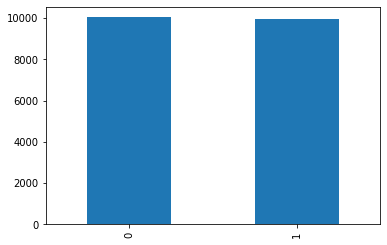

In [181]:
df['category'].value_counts().plot.bar()

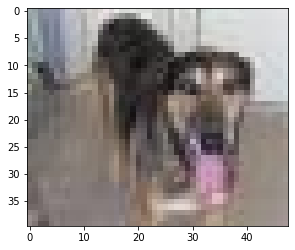

In [182]:
sample = random.choice(filenames)
image = load_img("./dogs-cats-train/"+sample)
plt.imshow(image)

In [183]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 batch_normalization_47 (Bat  (None, None, None, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, None, None, 32)    0         
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 batch_normalization_48 (Bat  (None, None, None, 64) 

In [184]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [185]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

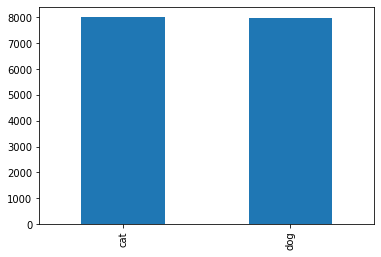

In [186]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

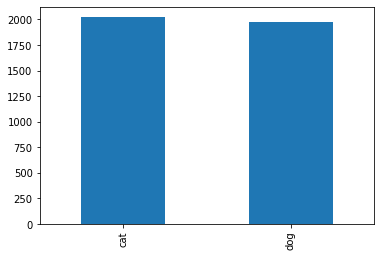

In [187]:
validate_df['category'].value_counts().plot.bar()

In [188]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [189]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dogs-cats-train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-cats-train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    batch_size=batch_size
)

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dogs-cats-train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 1 validated image filenames belonging to 1 classes.


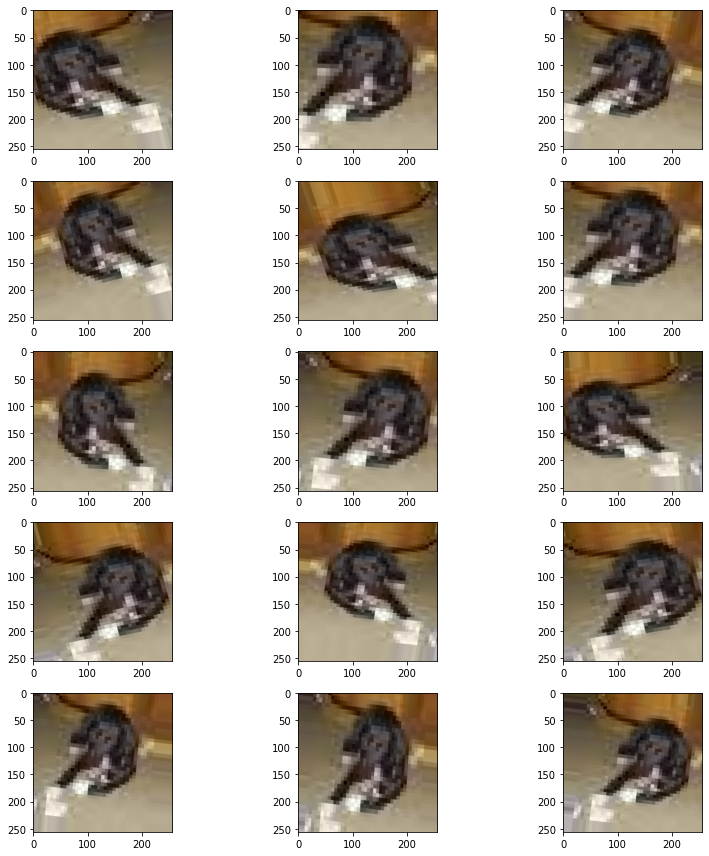

In [190]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [191]:
FAST_RUN = True

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\oem\AppData\Local\Temp\ipykernel_33412\1447037924.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
1066/1066 [==============================] - 1016s 952ms/step - loss: 0.8418 - accuracy: 0.5514 - val_loss: 0.6776 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 2/3
1066/1066 [==============================] - 1094s 1s/step - loss: 0.6919 - accuracy: 0.5977 - val_loss: 0.6658 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 3/3
1066/1066 [==============================] - 1434s 1s/step - loss: 0.6752 - accuracy: 0.6138 - val_loss: 0.6483 - val_accuracy: 0.6529 - lr: 0.0010


In [192]:
model.save_weights("model.h5")

KeyError: 'acc'

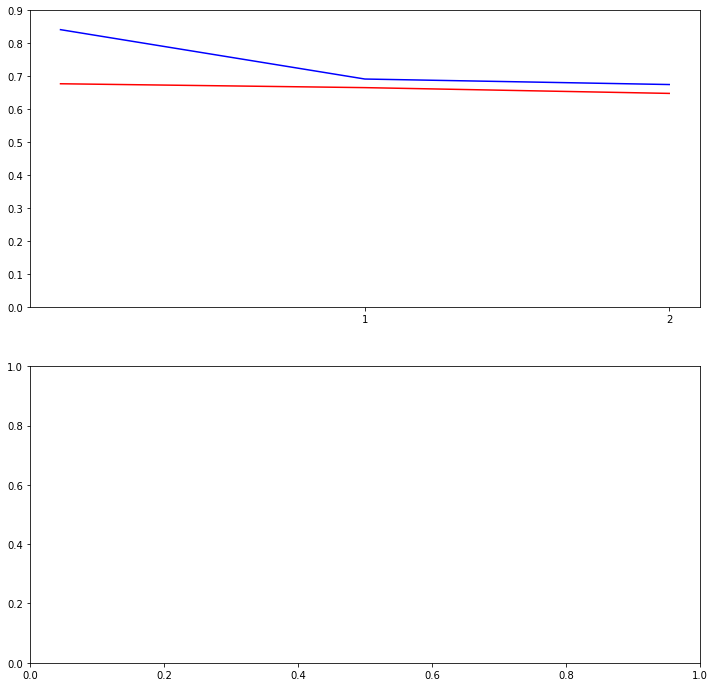

In [193]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("./dogs-cats-test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dogs-cats-test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dogs-cats-test/"+filename)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)